# Sampling crvUSD Liquidity from Historical Data

We examine the historical crvUSD liquidity in the relevant stableswap pools. Notice that there are three kinds of liquidity in our simulations:

1. collateral and crvUSD in LLAMMAs <- randomly sampled debt positions from empirical distribution (see `demo_borrowers.ipynb`).
2. crvUSD debt in StableSwap pools <- randomly sampled liquidity deposits from empirical distirbution (this notebook).
3. Liquidity on "External Markets" <- simulated using an Isotonic Regressor trained on historical 1Inch quotes (see `demo_slippage_curves.ipynb`).

### Liquidity and Debt

Intuitively we know that crvUSD liquidity in StableSwap pools (or other liquidity venues) is a function of the outstanding crvUSD debt. Over Q4 2023, we find that the total crvUSD liquidity in the four crvUSD Peg Keeper pools is meaningfully correlated to the outstanding debt in crvUSD markets ($R^2 = 0.6$).

To ensure we account for this correlation, we sample liquidity as follows:

1. Sample crvUSD debt for the simulation (`demo_borrowers.ipynb`).
2. Get the historic mean, variance, and covariance of StableSwap balances.
3. Scale the mean values such that the sum of mean crvUSD liquidity in StableSwap pools matches the historic ratio of crvUSD debt:liquidity.
4. Resample StableSwap balances from a multi-variate normal distribution using the scaled mean.

Example: Suppose our simulation has sampled a total of 100M crvUSD debt across all markets. Suppose further that the historic mean liquidity in the 4 StableSwap pools is (USDC/crvUSD: 10M, USDT/crvUSD: 10M, TUSD/crvUSD: 5M, UPSD/crvUSD: 2M) for a total mean liquidity of 27M. Finally, suppose the historic debt:liquidity ratio is 2.5. To achieve the ratio of 2.5, we must scale the mean liquidities by a scale factor of 1.48.

Therefore, the liquidity for the USDC/crvUSD pool will be sampled from a multi-variate normal distribution with mean 14.8M instead of 10M.

This allows us to simulate slight variations in the debt:liquidity ratio.

### Stressed Liquidity

The internal liquidity crunch scenario considers the case where crvUSD liquidity:debt is meaningfully below the historical average. We do this by taking the p99 debt:liquidity ratio observed historically. 

The resulting change in liquidity distribution is shown at the end of this notebook.

In [1]:
import numpy as np
from copy import deepcopy
import scipy.stats as stats
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import (
    get_historical_user_snapshots,
    get_historical_stableswap_stats,
    group_user_states,
)
from src.plotting.sim import plot_debt_to_liquidity
from src.configs import (
    LLAMMA_ALIASES,
    STABLESWAP_ADDRESSES,
    STABLESWAP_ALIASES,
    CRVUSD_USDC_ADDRESS,
    CRVUSD_TUSD_ADDRESS,
    CRVUSD_USDT_ADDRESS,
    CRVUSD_USDP_ADDRESS,
)
from src.sim.scenario import Scenario

%load_ext autoreload
%autoreload 2

### Historical Analysis

In [2]:
def plot_liquidity_over_time(df):
    df["peg"].plot(label="peg")
    df["crvUSD"].plot(label="crvUSD")
    df["supply"].plot(label="supply")
    plt.legend()
    plt.show()


def probplot(df):
    f, axs = plt.subplots(1, 2)
    stats.probplot(df["peg"], dist="norm", plot=axs[0])
    axs[0].set_title("Peg Coin Balance")
    stats.probplot(df["crvUSD"], dist="norm", plot=axs[1])
    axs[1].set_title("crvUSD Balance")
    plt.show()

In [3]:
start = int(datetime(2023, 10, 1).timestamp())
end = int(datetime(2024, 1, 1).timestamp())

dfs = get_historical_stableswap_stats(STABLESWAP_ADDRESSES, start, end)

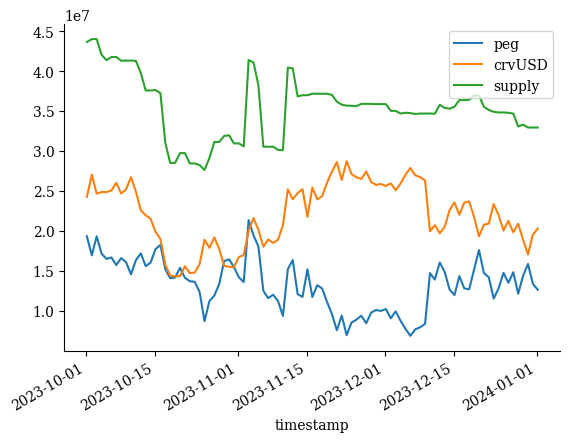

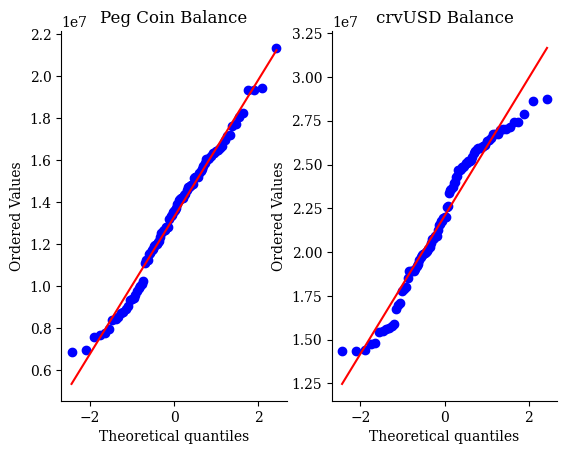

In [4]:
df = dfs[CRVUSD_USDC_ADDRESS]
plot_liquidity_over_time(df)
probplot(df)

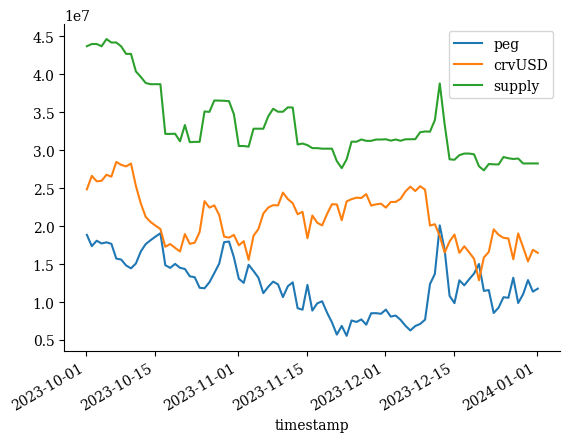

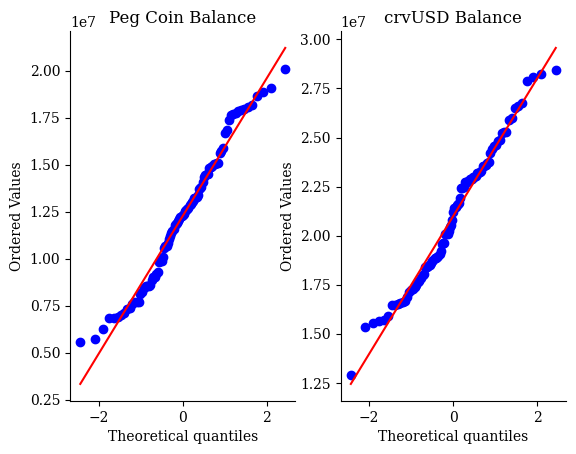

In [5]:
df = dfs[CRVUSD_USDT_ADDRESS]
plot_liquidity_over_time(df)
probplot(df)

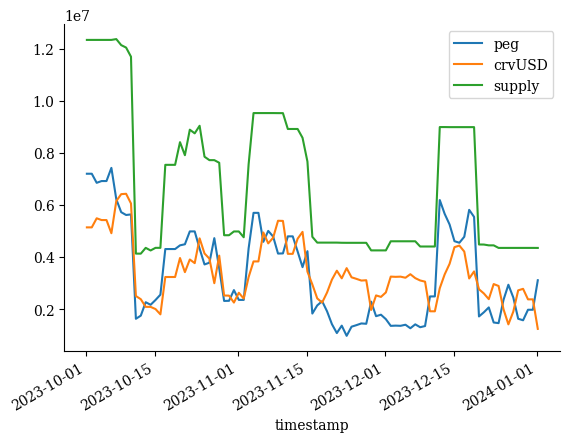

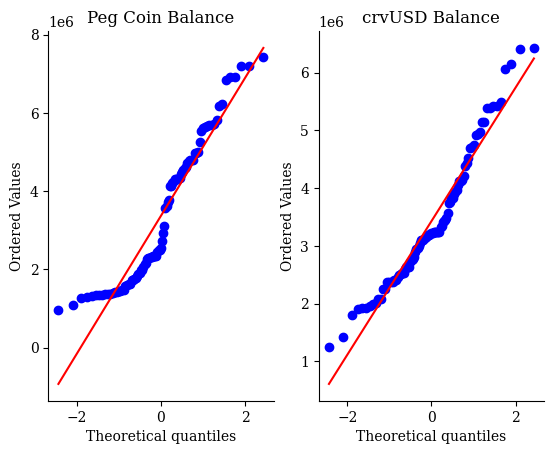

In [6]:
df = dfs[CRVUSD_TUSD_ADDRESS]
plot_liquidity_over_time(df)
probplot(df)

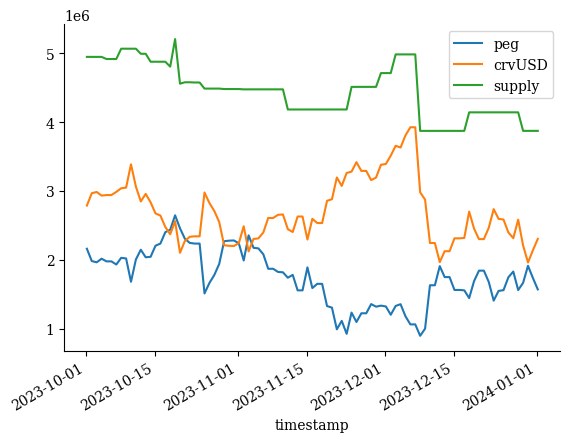

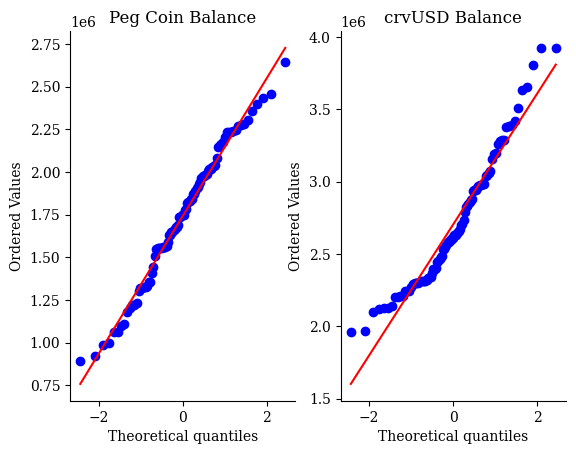

In [7]:
df = dfs[CRVUSD_USDP_ADDRESS]
plot_liquidity_over_time(df)
probplot(df)

In [8]:
df = dfs[CRVUSD_USDC_ADDRESS]
data = df[["peg", "crvUSD"]].values

# Estimate parameters
mean_vector = np.mean(data, axis=0)
covariance_matrix = np.cov(data, rowvar=False)

# Sample from the joint distribution
num_samples = 1000
samples = np.random.multivariate_normal(mean_vector, covariance_matrix, num_samples)

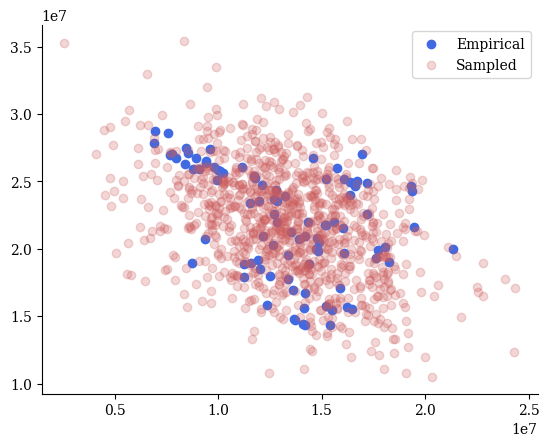

In [9]:
plt.scatter(data.T[0], data.T[1], color="royalblue", label="Empirical")
plt.scatter(samples.T[0], samples.T[1], color="indianred", label="Sampled", alpha=0.25)
plt.legend()

In [10]:
aliases = ["wsteth", "weth", "wbtc", "sfrxeth"]
grouped_data = []
for alias in aliases:
    market = LLAMMA_ALIASES[alias]
    user_states = get_historical_user_snapshots(market, start, end)
    grouped_data.append(group_user_states(user_states))

In [11]:
debts = pd.DataFrame(
    [
        df.rename(columns={"debt": alias})[alias]
        for alias, df in zip(aliases, grouped_data)
    ]
).T
debts["debt"] = debts.sum(axis=1)
debts = debts.resample("1d").mean()
debts.head()

,wsteth,weth,wbtc,sfrxeth,debt
datetime,,,,,
2023-09-30,4.195846e+07,5.762736e+06,4.389156e+07,9.231491e+06,1.008442e+08
2023-10-01,4.273815e+07,5.757250e+06,4.395752e+07,9.261179e+06,1.017141e+08
2023-10-02,4.292228e+07,6.207339e+06,4.335811e+07,9.079936e+06,1.015677e+08
2023-10-03,4.069514e+07,6.170375e+06,4.701885e+07,1.000663e+07,1.038910e+08
2023-10-04,4.056311e+07,6.148231e+06,4.705074e+07,1.001299e+07,1.037751e+08


In [12]:
liquidity = pd.DataFrame(
    [
        df.rename(columns={"crvUSD": STABLESWAP_ALIASES[address]})[
            STABLESWAP_ALIASES[address]
        ]
        for address, df in dfs.items()
    ]
).T
liquidity["liquidity"] = liquidity.sum(axis=1)
liquidity = liquidity.resample("1d").mean()
liquidity.head()

,usdc_stableswap,usdt_stableswap,tusd_stableswap,usdp_stableswap,liquidity
timestamp,,,,,
2023-10-01,2.429347e+07,2.485379e+07,5.136401e+06,2.787582e+06,5.707124e+07
2023-10-02,2.704362e+07,2.663157e+07,5.136401e+06,2.966675e+06,6.177826e+07
2023-10-03,2.467229e+07,2.591386e+07,5.484620e+06,2.985026e+06,5.905579e+07
2023-10-04,2.487149e+07,2.598123e+07,5.416854e+06,2.932290e+06,5.920186e+07
2023-10-05,2.486477e+07,2.677640e+07,5.416854e+06,2.940335e+06,5.999836e+07


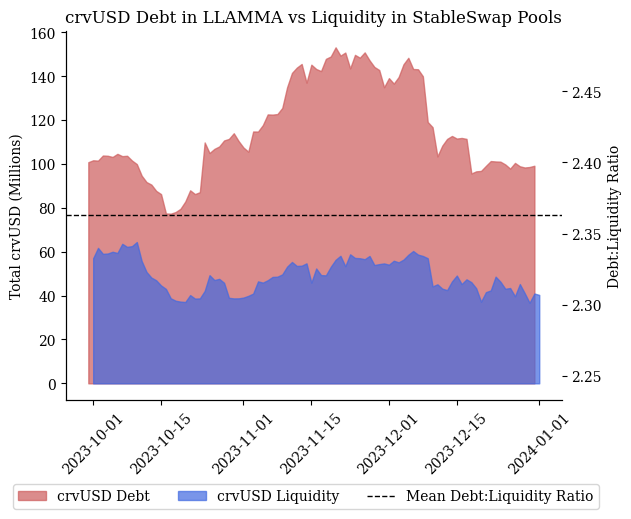

In [13]:
_ = plot_debt_to_liquidity(debts, liquidity)

In [14]:
ratio = (debts["debt"] / liquidity["liquidity"]).dropna()
ratio.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

count    92.000000
mean      2.362817
std       0.362057
min       1.551653
1%        1.617468
25%       2.169457
50%       2.440397
75%       2.606633
99%       3.018794
max       3.164624
dtype: float64

In [15]:
target_ratio = ratio.mean()
total_debt = debts["debt"].iloc[-1]  # the sampled debt (from the resampling)
total_debt, target_ratio

(99219673.62583779, 2.362817493702465)

In [16]:
scale_factor = total_debt / (target_ratio * liquidity["liquidity"].mean())
scale_factor  # scale factor required to center liquidity given sampled debt

0.8534813891066512

In [17]:
np.corrcoef(debts["debt"], liquidity["liquidity"])

array([[1.        , 0.58467953],
       [0.58467953, 1.        ]])

In [18]:
num_samples = 100
sampled_liquidity = []
config = {}
for address, df in dfs.items():
    data = df[["peg", "crvUSD"]].values
    # Estimate parameters
    mean_vector = np.mean(data, axis=0) * scale_factor  # scale mean vector
    covariance_matrix = np.cov(data, rowvar=False)
    # Sample from the joint distribution
    samples = np.random.multivariate_normal(mean_vector, covariance_matrix, num_samples)
    sampled_liquidity.append(samples.T[1])

    config[address] = {
        "mean_vector": np.mean(data, axis=0).tolist(),
        "covariance_matrix": covariance_matrix.tolist(),
    }

config["target_ratio"] = target_ratio

sampled_liquidity = np.array(sampled_liquidity)
sampled_liquidity.shape

(4, 100)

In [19]:
aliases = [STABLESWAP_ALIASES[address] for address in dfs.keys()]
sampled_liquidity_df = pd.DataFrame(sampled_liquidity.T, columns=aliases)
sampled_liquidity_df["liquidity"] = sampled_liquidity_df.sum(axis=1)
sampled_liquidity_df["ratio"] = total_debt / sampled_liquidity_df["liquidity"]
sampled_liquidity_df.head()

,usdc_stableswap,usdt_stableswap,tusd_stableswap,usdp_stableswap,liquidity,ratio
0,1.051129e+07,1.430098e+07,1.778707e+06,3.302757e+06,2.989373e+07,3.319079
1,2.410468e+07,2.030452e+07,3.010693e+06,3.007946e+06,5.042783e+07,1.967558
2,1.626782e+07,1.769032e+07,3.084605e+06,1.692526e+06,3.873527e+07,2.561481
3,1.764202e+07,1.302737e+07,1.353217e+06,1.515993e+06,3.353860e+07,2.958373
4,2.086946e+07,1.672202e+07,4.482179e+06,2.447918e+06,4.452158e+07,2.228575


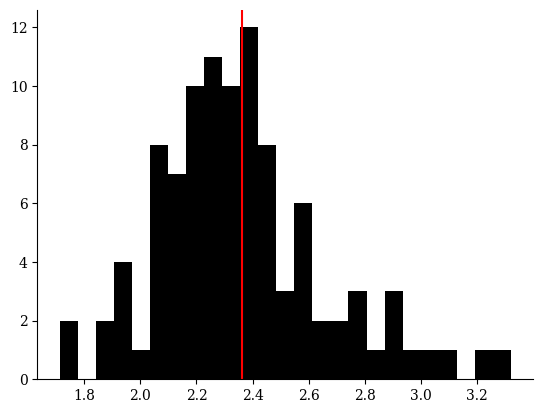

In [20]:
f, ax = plt.subplots()

sampled_liquidity_df["ratio"].hist(
    grid=False, bins=num_samples // 4, ax=ax, color="black"
)
ax.axvline(target_ratio, color="red", label="target ratio", c="red")

In [21]:
config

{'0x4dece678ceceb27446b35c672dc7d61f30bad69e': {'mean_vector': [13301725.774722604,
   22063704.151237566],
  'covariance_matrix': [[10444039839852.707, -5343676995232.574],
   [-5343676995232.574, 15676536217749.545]]},
 '0x390f3595bca2df7d23783dfd126427cceb997bf4': {'mean_vector': [12270429.929307098,
   21005844.782402404],
  'covariance_matrix': [[13307829192532.402, -1488878431113.9937],
   [-1488878431113.9937, 12190509648961.377]]},
 '0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0': {'mean_vector': [3366878.6913696276,
   3426015.4241633415],
  'covariance_matrix': [[3290548249887.2573, 1454808246855.219],
   [1454808246855.219, 1355928295052.5437]]},
 '0xca978a0528116dda3cba9acd3e68bc6191ca53d0': {'mean_vector': [1742667.0215639863,
   2705393.8762533944],
  'covariance_matrix': [[159751659439.31552, -110777988195.62952],
   [-110777988195.62952, 209304692955.21835]]},
 'target_ratio': 2.362817493702465}

### Resampling Liquidity from Config

The config is generated by the script `scripts/gen_liquidity_config.py`.

In [26]:
aliases = ["wsteth", "weth", "wbtc", "sfrxeth"]
baseline_ = Scenario("baseline_micro", aliases)
internal_crunch_ = Scenario("internal_crunch", aliases)

[INFO][10:50:48][src.sim.scenario]-16268: Fetching wsteth market from subgraph
[INFO][10:50:51][src.sim.scenario]-16268: Market snapshot as 2024-01-15 10:02:35
[INFO][10:50:51][src.sim.scenario]-16268: Bands snapshot as 2024-01-14 19:02:47
[INFO][10:50:51][src.sim.scenario]-16268: Users snapshot as 2024-01-15 07:19:35
[INFO][10:50:51][src.sim.scenario]-16268: Fetching weth market from subgraph
[INFO][10:50:54][src.sim.scenario]-16268: Market snapshot as 2024-01-15 10:02:35
[INFO][10:50:54][src.sim.scenario]-16268: Bands snapshot as 2024-01-14 19:02:47
[INFO][10:50:54][src.sim.scenario]-16268: Users snapshot as 2024-01-15 07:19:35
[INFO][10:50:54][src.sim.scenario]-16268: Fetching wbtc market from subgraph
[INFO][10:50:57][src.sim.scenario]-16268: Market snapshot as 2024-01-15 10:02:35
[INFO][10:50:57][src.sim.scenario]-16268: Bands snapshot as 2024-01-14 19:02:47
[INFO][10:50:57][src.sim.scenario]-16268: Users snapshot as 2024-01-15 07:19:35
[INFO][10:50:57][src.sim.scenario]-16268: Fe

In [27]:
baseline = deepcopy(baseline_)
og_liquidity = baseline.total_crvusd_liquidity / 1e18
og_debt = baseline.total_debt / 1e18
og_ratio = og_debt / og_liquidity
print(f"Original crvUSD Liquidity: {og_liquidity:,.0f}")
print(f"Original crvUSD Debt: {og_debt:,.0f}")
print(f"Original ratio: {og_ratio:.2f}")

Original crvUSD Liquidity: 32,910,877
Original crvUSD Debt: 89,352,783
Original ratio: 2.71


In [28]:
baseline.prepare_for_run()  # resamples debt and liquidity

In [29]:
liquidity = baseline.total_crvusd_liquidity / 1e18
debt = baseline.total_debt / 1e18
print(f"Resampled crvUSD Liquidity: {liquidity:,.0f}")
print(f"Resampled crvUSD Debt: {debt:,.0f}")
print(f"Resampled ratio: {debt / liquidity:.2f}")

Resampled crvUSD Liquidity: 49,783,735
Resampled crvUSD Debt: 127,028,537
Resampled ratio: 2.55


In [30]:
resampled = pd.DataFrame(columns=["liquidity", "debt", "ratio"])
for _ in range(100):
    scenario = deepcopy(baseline_)
    scenario.prepare_for_run()
    liquidity = scenario.total_crvusd_liquidity / 1e18
    debt = scenario.total_debt / 1e18
    ratio = debt / liquidity
    resampled.loc[len(resampled)] = [liquidity, debt, ratio]
resampled

,liquidity,debt,ratio
0,5.239341e+07,1.240617e+08,2.367886
1,6.004017e+07,1.218260e+08,2.029075
2,6.596173e+07,1.510568e+08,2.290067
3,6.908169e+07,1.470400e+08,2.128494
4,3.205549e+07,9.858389e+07,3.075414
...,...,...,...
95,6.039342e+07,1.459469e+08,2.416602
96,3.532440e+07,9.809630e+07,2.777013
97,5.189331e+07,1.333128e+08,2.568979
98,8.023816e+07,1.877661e+08,2.340109


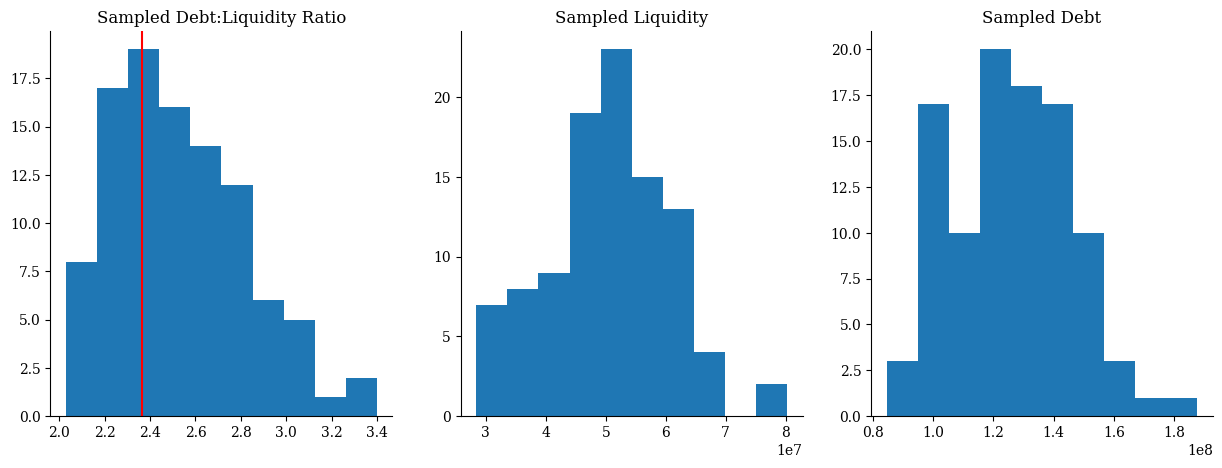

In [31]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
resampled["ratio"].hist(grid=False, bins=10, ax=axs[0])
axs[0].set_title("Sampled Debt:Liquidity Ratio")
axs[0].axvline(
    baseline.target_liquidity_ratio, color="red", label="Target Ratio", c="red"
)
resampled["liquidity"].hist(grid=False, bins=10, ax=axs[1])
axs[1].set_title("Sampled Liquidity")
resampled["debt"].hist(grid=False, bins=10, ax=axs[2])
axs[2].set_title("Sampled Debt")
print()

## Stressed Liquidity

Apply the internal crunch liquidity shock and observe the stressed liquidity paths that are generated.

In [32]:
from src.sim.shocks import STRATEGIES
from src.metrics import DEFAULT_METRICS

internal_crunch_strat = STRATEGIES["internal_crunch"](DEFAULT_METRICS)
internal_crunch_strat.apply_shocks(internal_crunch_)

In [36]:
resampled = pd.DataFrame(columns=["liquidity", "debt", "ratio"])
for _ in range(100):
    scenario = deepcopy(internal_crunch_)
    scenario.prepare_for_run()
    liquidity = scenario.total_crvusd_liquidity / 1e18
    debt = scenario.total_debt / 1e18
    ratio = debt / liquidity
    resampled.loc[len(resampled)] = [liquidity, debt, ratio]
resampled

,liquidity,debt,ratio
0,4.215933e+07,1.283338e+08,3.044019
1,2.919961e+07,8.942554e+07,3.062559
2,3.594054e+07,1.057774e+08,2.943124
3,3.982097e+07,1.058338e+08,2.657740
4,5.567648e+07,1.558623e+08,2.799429
...,...,...,...
95,3.513059e+07,1.150905e+08,3.276077
96,3.772262e+07,1.137225e+08,3.014703
97,2.873562e+07,1.143059e+08,3.977847
98,5.442427e+07,1.615277e+08,2.967934


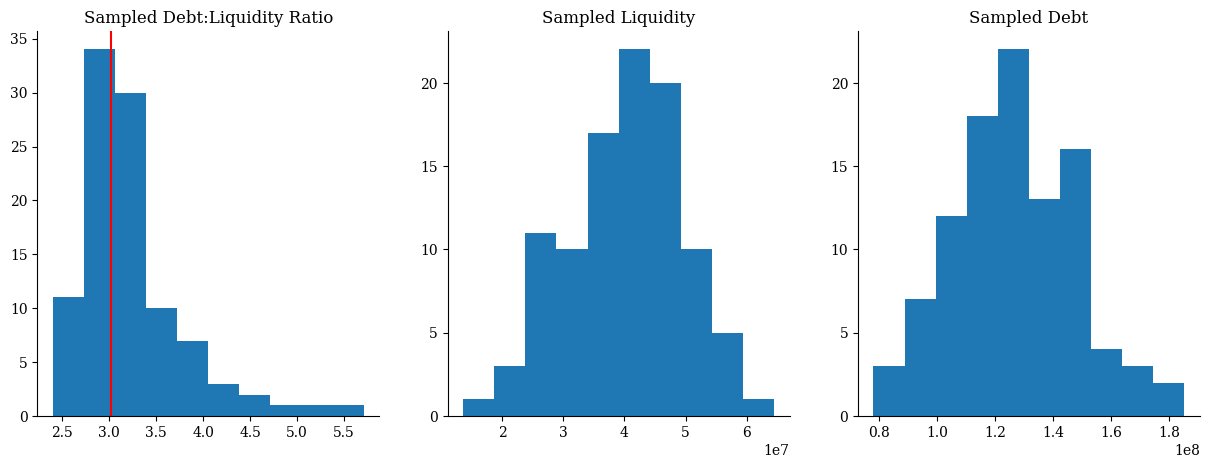

In [37]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
resampled["ratio"].hist(grid=False, bins=10, ax=axs[0])
axs[0].set_title("Sampled Debt:Liquidity Ratio")
axs[0].axvline(
    internal_crunch_.target_liquidity_ratio, color="red", label="Target Ratio", c="red"
)
resampled["liquidity"].hist(grid=False, bins=10, ax=axs[1])
axs[1].set_title("Sampled Liquidity")
resampled["debt"].hist(grid=False, bins=10, ax=axs[2])
axs[2].set_title("Sampled Debt")
print()